In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.9.2


Import MNIST dataset.

In [ ]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize test and train sets
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def create_model():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Confirm that our model can achieve above 98% accuracy on MNIST dataset.

In [ ]:
base_model = create_model()
base_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 19s 4ms/step - loss: 0.1391 - accuracy: 0.9575 - val_loss: 0.0476 - val_accuracy: 0.9845
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0528 - accuracy: 0.9840 - val_loss: 0.0373 - val_accuracy: 0.9886
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0385 - val_accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0303 - accuracy: 0.9908 - val_loss: 0.0367 - val_accuracy: 0.9884
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0250 - accuracy: 0.9919 - val_loss: 0.0378 - val_accuracy: 0.9884


# Check the accuracy drop



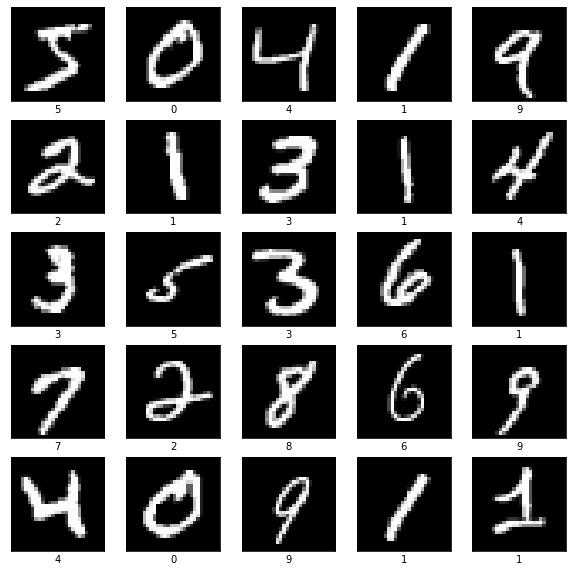

In [ ]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Make Histogram for how centered and aligned the data is

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c1f49e3d0>,
      dtype=object)

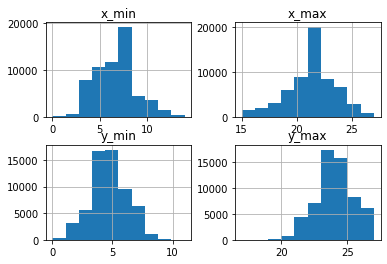

In [ ]:
def digit_area(mnist_image):
  mnist_image = np.squeeze(mnist_image, axis=2)

  # Extract the list of columns that contain at least 1 pixel from the digit
  x_nonzero = np.nonzero(np.amax(mnist_image, 0))
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)

  # Extract the list of rows that contain at least 1 pixel from the digit
  y_nonzero = np.nonzero(np.amax(mnist_image, 1))
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)

  return [x_min, x_max, y_min, y_max]

digit_area_rows = []
for image in train_images:
  digit_area_row = digit_area(image)
  digit_area_rows.append(digit_area_row)
digit_area_df = pd.DataFrame(
  digit_area_rows,
  columns=['x_min', 'x_max', 'y_min', 'y_max']
)
digit_area_df.hist()

## Adjust the Alignment

In [ ]:
# Define data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.2
)

# Generate augmented data from MNIST dataset
train_generator = datagen.flow(train_images, train_labels)
test_generator = datagen.flow(test_images, test_labels)

## Post alignment model data and accuracy

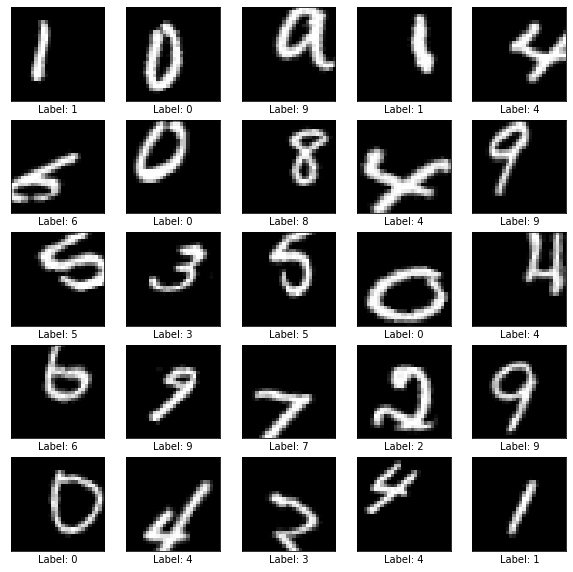

In [ ]:
augmented_images, augmented_labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
    plt.xlabel('Label: %d' % augmented_labels[i])
plt.show()

In [ ]:
base_model.evaluate(test_generator)

313/313 [==============================] - 4s 12ms/step - loss: 5.5625 - accuracy: 0.3244


[5.562522888183594, 0.32440000772476196]

Accuracy drops to 40%

# Improve accuracy with data augmentation



In [ ]:
improved_model = create_model()
improved_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.9520 - accuracy: 0.6939 - val_loss: 0.4762 - val_accuracy: 0.8669
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4595 - accuracy: 0.8626 - val_loss: 0.3507 - val_accuracy: 0.8944
Epoch 3/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3704 - accuracy: 0.8904 - val_loss: 0.2692 - val_accuracy: 0.9183
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3261 - accuracy: 0.9016 - val_loss: 0.2717 - val_accuracy: 0.9149
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3002 - accuracy: 0.9107 - val_loss: 0.2606 - val_accuracy: 0.9216


# Convert to TensorFlow Lite


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

from google.colab import files
files.download('mnist.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>